# Stock Price Analysis Using the NASDAQ REST API
## by [Dan Hillman](https://danhillman.dev)
## BEFORE READING
At the time this project was pushed to GitHub, the days observed in the data are stock prices at market close on *19 August 2019* and *20 August 2019*. 

### 1. What is the purpose of this project?
NASDAQ provides free access to an API where a user can download a CSV containing a list of all company names listed on a specific US stock exchange (in addition to other information). This CSV can be parsed to create visualizations and analysis of day to day stock price movements. 
### 2. What is contained in the data?
The information in the CSV appears to be updated at ~6:00PM EST on weekdays with information for that day's market closing. The two most useful quantitative columns in the CSV are the closing price and market cap for each stock. Useful qualitative columns include sector, industry, and the exchange each stock is listed on.
### 3. How is the data downloaded?
The [NASDAQ company list page](https://www.nasdaq.com/screening/company-list.aspx) provides a REST API for downloading the company list CSV for each US stock exchange. The link for each company list CSV for each exchange can be used by the pandas `read_csv()` method to read in the data to a dataframe. The CSV for each exchange will be combined into a final dataframe containing data for all 3 US exchanges.
### 4. What insights can be derived from this analysis?
The stock price difference from two points in time are what can be observed in this notebook. This notebook could make a good, free, makeshift dashboard displaying price information from the previous day's trading if a user were to automate when this notebook is run.

## Import Libraries and Initialize Setup

In [245]:
import pandas as pd
import numpy as np
import re
import time
import datetime
import matplotlib.pyplot as plt
import matplotlib.style as style
style.use('seaborn-poster')
style.use('ggplot')

## `create_stocks_df` Function
### 1. What does the function do?
The function returns a dataframe with combined stock data from all 3 US stock exchanges. The function also cleans the data of unnecessary columns and any rows with NaNs in important columns. 
### 2. What data cleaning steps are taken?
#### Column names are converted to snake_case
"snake_case" is the recommended format for variable names in Python. The columns in the resulting dataframe are processed through a function named `convert_to_snake_case` to create consistency in column names.
#### Unnecessary columns are dropped
The columns "Summary Quote" and "IPOyear" are removed because no important insights can be derived from those columns.
#### Ambiguously named columns are renamed
The column "last_sale" is renamed to "price".
#### Duplicate rows are evaluated and removed
There are several duplicate stocks listed on both the NASDAQ and the NYSE. If a stock is listed on the NASDAQ and NYSE, the stock is removed from the NASDAQ and allowed to remain on the NYSE.
#### Market cap data is converted from string to float
The "market_cap" column originally comes in the format "3.00B" or "45.2M". The non-numeric characters are removed and the resulting value multiplied by either 1,000,000,000 or 1,000,000 depending on whether a "B" or an "M" was present in the string.

In [265]:
def create_stocks_df():
    combined = pd.DataFrame()
    exchange_names_strings_list = ["nasdaq","nyse","amex"]
    index_list = np.array([])

    for name in exchange_names_strings_list:
        exchange_tickers_url = "http://www.nasdaq.com/screening/companies-by-name.aspx?letter=0&exchange=" + \
        name + "&render=download"
        current = pd.read_csv(exchange_tickers_url)
        time.sleep(5) #take 5 seconds to ensure the API will not ban IP address.
        current.loc[:,"exchange"] = name.upper()
        if combined.empty:
            combined = combined.append(current)
        else:
            combined = pd.concat([combined,current])
    
    combined.dropna(axis=1,how="all",inplace=True)
    combined.drop(["Summary Quote","IPOyear"],axis=1,inplace=True)
        
    formatted_columns = [convert_to_snake_case(col) for col in combined.columns]
    combined.columns = formatted_columns
    
    combined.rename({"last_sale":"price"},axis=1,inplace=True)
    combined.reset_index(inplace=True,drop=True)
    
    duplicates_bool = combined.loc[:,"symbol"].duplicated(keep=False)
    duplicates = combined.loc[duplicates_bool,:]
    
    nyse_duplicates_bool = duplicates.loc[:,"exchange"] == "NYSE"
    nasdaq_duplicates_bool = duplicates.loc[:,"exchange"] == "NASDAQ"
    amex_duplicates_bool = duplicates.loc[:,"exchange"] == "AMEX"

    nyse_duplicates_symbols = duplicates.loc[nyse_duplicates_bool,"symbol"]
    nasdaq_duplicates_symbols = duplicates.loc[nasdaq_duplicates_bool,"symbol"]
    amex_duplicates_symbols = duplicates.loc[amex_duplicates_bool,"symbol"]

    amex_in_nasdaq_bool = amex_duplicates_symbols.isin(nasdaq_duplicates_symbols)
    amex_in_nasdaq_true_indexes = (amex_in_nasdaq_bool == True).index.to_list()
    index_list = np.append(index_list,amex_in_nasdaq_true_indexes)

    nasdaq_in_nyse_bool = nasdaq_duplicates_symbols.isin(nyse_duplicates_symbols)
    nasdaq_in_nyse_true_indexes = (nasdaq_in_nyse_bool == True).index.to_list()
    index_list = np.append(index_list,nasdaq_in_nyse_true_indexes)

    index_list = index_list.astype(int)
    combined.drop(index_list,axis=0,inplace=True)
    
    analysis_columns = ["price","market_cap","sector","industry"]
    combined.dropna(axis=0,subset=analysis_columns,inplace=True)
    
    billion_mc = combined.loc[:,"market_cap"].str.contains("B")
    million_mc = combined.loc[:,"market_cap"].str.contains("M")
    
    combined.loc[:,"market_cap"] = combined.loc[:,"market_cap"].str.replace("B","") \
                                                               .str.replace("M","") \
                                                               .str.replace("$","") \
                                                               .astype("float")

    combined.loc[billion_mc,"market_cap"] = combined.loc[billion_mc,"market_cap"] * 1000000000
    combined.loc[million_mc,"market_cap"] = combined.loc[million_mc,"market_cap"] * 1000000
    
    return combined

In [2]:
def convert_to_snake_case(name):
    s1 = re.sub('(.)([A-Z][a-z]+)', r'\1_\2', name)
    return re.sub('([a-z0-9])([A-Z])', r'\1_\2', s1).lower()

## Download "Original" Stock DataFrame
The first stock dataframe is assigned to a variable named `stocks_original` where the stock values for the first point in time will be stored. A timestamp is included in the code as well to display when the first download occurred.

In [4]:
stocks_original = create_stocks_df()
stocks_original_timestamp = datetime.datetime.now()
stocks_original.drop("market_cap",axis=1,inplace=True)
print("Original Download at: {}".format(stocks_original_timestamp))

Original Download at: 2019-08-20 15:47:50.245269


In [14]:
stocks_original.head()

,symbol,name,price,sector,industry,exchange
0,YI,"111, Inc.",2.8600,Health Care,Medical/Nursing Services,NASDAQ
1,PIH,"1347 Property Insurance Holdings, Inc.",5.0739,Finance,Property-Casualty Insurers,NASDAQ
2,PIHPP,"1347 Property Insurance Holdings, Inc.",26.0000,Finance,Property-Casualty Insurers,NASDAQ
3,TURN,180 Degree Capital Corp.,2.1700,Finance,Finance/Investors Services,NASDAQ
4,FLWS,"1-800 FLOWERS.COM, Inc.",18.7300,Consumer Services,Other Specialty Stores,NASDAQ


In [266]:
stocks_original.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4946 entries, 0 to 6950
Data columns (total 6 columns):
symbol      4946 non-null object
name        4946 non-null object
price       4946 non-null float64
sector      4946 non-null object
industry    4946 non-null object
exchange    4946 non-null object
dtypes: float64(1), object(5)
memory usage: 270.5+ KB


## Download "Later" Stock DataFrame
The second stock dataframe is assigned to a variable named `stocks_later` where the stock values for the second point in time will be stored. A timestamp is included in the code as well to display when the "later" download occurred. Only the symbol, price, and market_cap columns are kept in the "later" dataframe to make merging dataframes more simple.

In [18]:
stocks_later = create_stocks_df()
stocks_later_timestamp = datetime.datetime.now()
stocks_later.drop(["name","sector","industry","exchange"],axis=1,inplace=True)
stocks_later.rename({"price":"new_price",},axis=1,inplace=True)
print("Later Download at: {}".format(stocks_later_timestamp))

Later Download at: 2019-08-20 19:49:18.711567


In [267]:
stocks_later.head()

,symbol,new_price,market_cap
0,YI,2.89,2.359900e+08
1,PIH,4.90,2.946000e+07
2,PIHPP,25.61,1.793000e+07
3,TURN,2.21,6.878000e+07
4,FLWS,18.64,1.200000e+09


In [268]:
stocks_later.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4946 entries, 0 to 6952
Data columns (total 3 columns):
symbol        4946 non-null object
new_price     4946 non-null float64
market_cap    4946 non-null float64
dtypes: float64(2), object(1)
memory usage: 154.6+ KB


## Merging the "Original" and "Later" Stock DataFrames
The `stocks_later` will be merged into `stocks_original` to create a `stocks_dif` dataframe. An INNER JOIN on the "symbol" column will be used for the merge to ensure there are no missing values and only values common between the two dataframes will be included. `stocks_dif` will include calculations for the dollar amount change and the % change in price for each stock.

In [286]:
stocks_dif = stocks_original.merge(stocks_later,how="inner",on="symbol")
stocks_dif.loc[:,"$_change"] = stocks_dif.loc[:,"new_price"] - stocks_dif.loc[:,"price"]
stocks_dif.loc[:,"%_change"] = (round((stocks_dif.loc[:,"$_change"] / stocks_dif.loc[:,"price"]),4)) * 100
stocks_dif.head()

,symbol,name,price,sector,industry,exchange,new_price,market_cap,$_change,%_change
0,YI,"111, Inc.",2.8600,Health Care,Medical/Nursing Services,NASDAQ,2.89,2.359900e+08,0.0300,1.05
1,PIH,"1347 Property Insurance Holdings, Inc.",5.0739,Finance,Property-Casualty Insurers,NASDAQ,4.90,2.946000e+07,-0.1739,-3.43
2,PIHPP,"1347 Property Insurance Holdings, Inc.",26.0000,Finance,Property-Casualty Insurers,NASDAQ,25.61,1.793000e+07,-0.3900,-1.50
3,TURN,180 Degree Capital Corp.,2.1700,Finance,Finance/Investors Services,NASDAQ,2.21,6.878000e+07,0.0400,1.84
4,FLWS,"1-800 FLOWERS.COM, Inc.",18.7300,Consumer Services,Other Specialty Stores,NASDAQ,18.64,1.200000e+09,-0.0900,-0.48


In [287]:
stocks_dif.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4946 entries, 0 to 4945
Data columns (total 10 columns):
symbol        4946 non-null object
name          4946 non-null object
price         4946 non-null float64
sector        4946 non-null object
industry      4946 non-null object
exchange      4946 non-null object
new_price     4946 non-null float64
market_cap    4946 non-null float64
$_change      4946 non-null float64
%_change      4946 non-null float64
dtypes: float64(5), object(5)
memory usage: 425.0+ KB


## `create_weights` Function
When calculating the performance by sector, industry, or exchange, each stock carries a different weight within those parameters. The market capitalization of a stock is used to determine its weight within a parameter. The `create_weights` function will calculate three columns: weight within the parameter, weight overall compared to other stocks, and the weighted % change within a parameter.

In [288]:
def create_weights(df, parameter):
    for dimension in df.loc[:,parameter].unique():
        dimension_bool = df.loc[:,parameter] == dimension
        df.loc[dimension_bool,"mc_"+parameter+"_weight"] = df.loc[dimension_bool,"market_cap"] / \
                                                           df.loc[dimension_bool,"market_cap"].sum()
        df.loc[dimension_bool,"mc_"+parameter+"_weight_overall"] = df.loc[dimension_bool,"market_cap"] / \
                                                                   df.loc[:,"market_cap"].sum()
        df.loc[dimension_bool,parameter+"_weighted_%_change"] = df.loc[dimension_bool,"%_change"] * \
                                                                df.loc[dimension_bool,"mc_"+parameter+"_weight"]

In [289]:
parameter_columns = ["sector","industry","exchange"]
for parameter in parameter_columns:
    create_weights(stocks_dif,parameter)

In [290]:
stocks_dif.head()

,symbol,name,price,sector,industry,exchange,new_price,market_cap,$_change,%_change,mc_sector_weight,mc_sector_weight_overall,sector_weighted_%_change,mc_industry_weight,mc_industry_weight_overall,industry_weighted_%_change,mc_exchange_weight,mc_exchange_weight_overall,exchange_weighted_%_change
0,YI,"111, Inc.",2.8600,Health Care,Medical/Nursing Services,NASDAQ,2.89,2.359900e+08,0.0300,1.05,0.000049,5.645500e-06,0.000051,0.001537,5.645500e-06,0.001614,0.000017,5.645500e-06,0.000018
1,PIH,"1347 Property Insurance Holdings, Inc.",5.0739,Finance,Property-Casualty Insurers,NASDAQ,4.90,2.946000e+07,-0.1739,-3.43,0.000005,7.047605e-07,-0.000018,0.000062,7.047605e-07,-0.000213,0.000002,7.047605e-07,-0.000007
2,PIHPP,"1347 Property Insurance Holdings, Inc.",26.0000,Finance,Property-Casualty Insurers,NASDAQ,25.61,1.793000e+07,-0.3900,-1.50,0.000003,4.289327e-07,-0.000005,0.000038,4.289327e-07,-0.000057,0.000001,4.289327e-07,-0.000002
3,TURN,180 Degree Capital Corp.,2.1700,Finance,Finance/Investors Services,NASDAQ,2.21,6.878000e+07,0.0400,1.84,0.000012,1.645398e-06,0.000022,0.203702,1.645398e-06,0.374812,0.000005,1.645398e-06,0.000009
4,FLWS,"1-800 FLOWERS.COM, Inc.",18.7300,Consumer Services,Other Specialty Stores,NASDAQ,18.64,1.200000e+09,-0.0900,-0.48,0.000193,2.870715e-05,-0.000093,0.006733,2.870715e-05,-0.003232,0.000088,2.870715e-05,-0.000042


## Best Performing Stocks Overall (US)

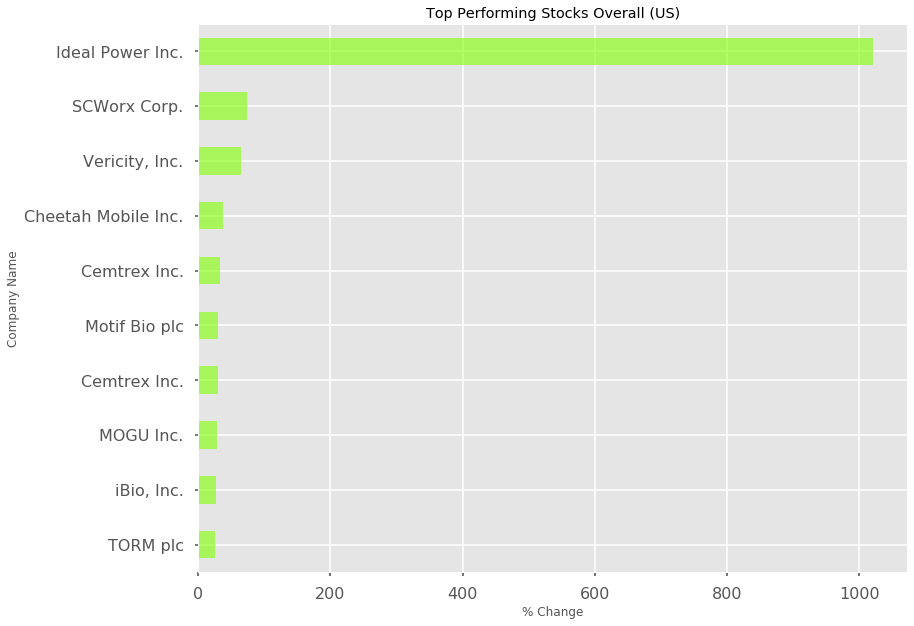

In [291]:
top_stocks = stocks_dif.copy()
top_stocks = top_stocks.loc[:,["name","%_change"]]
top_stocks.sort_values(by="%_change",inplace=True,ascending=False)
top_stocks = top_stocks.head(10)[ : :-1]
top_stocks.plot.barh(y="%_change",x="name",color="chartreuse",legend=False,alpha=0.6)
plt.gca().set(xlabel="% Change")
plt.title("Top Performing Stocks Overall (US)")
plt.xlabel("% Change")
plt.ylabel("Company Name")
plt.tight_layout()
plt.show()

## Worst Performing Stocks Overall (US)

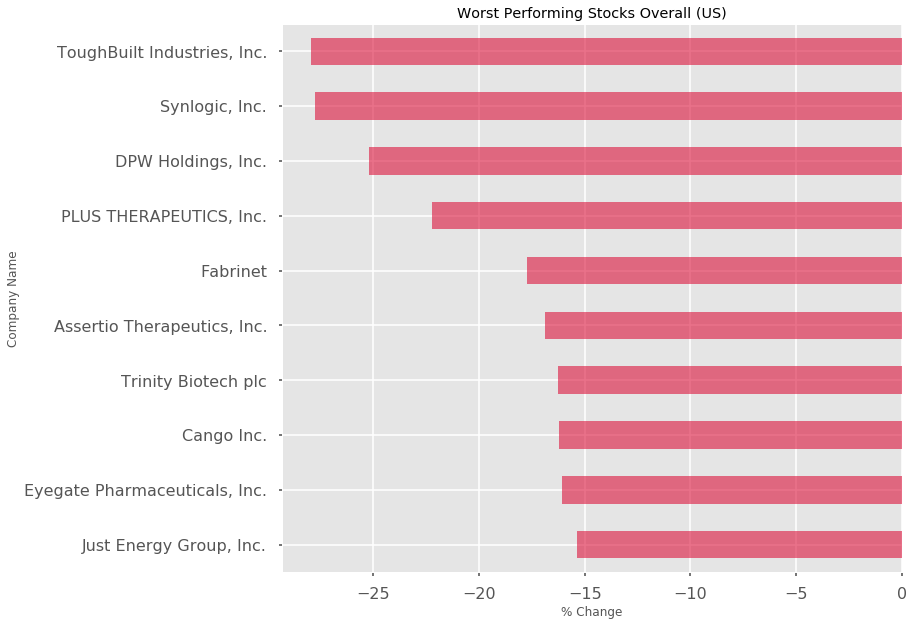

In [292]:
top_stocks = stocks_dif.copy()
top_stocks = top_stocks.loc[:,["name","%_change"]]
top_stocks.sort_values(by="%_change",inplace=True)
top_stocks = top_stocks.head(10)[ : :-1]
top_stocks.plot.barh(x="name",y="%_change",color="crimson",legend=False,alpha=0.6)
plt.gca().set(xlabel="% Change",ylabel="Company Name")
plt.title("Worst Performing Stocks Overall (US)")
plt.tight_layout()
plt.show()

## Performance by Sector

In [293]:
def create_sector_diverging_bars(df,parameter):
    values_name = parameter+"_weighted_%_change"
    parameter_name = parameter.capitalize()
    df_copy = df.copy()
    group = df_copy.loc[:,[parameter,values_name]].groupby(parameter).sum()
    group.sort_values(by=values_name,inplace=True)
    
    group.loc[:,"colors"] = ["crimson" if x < 0 else "green" for x in group.loc[:,values_name]]
    plt.hlines(y=group.index, xmin=0, xmax=group.loc[:,values_name], color=group.colors, alpha=0.4, linewidth=5)
    plt.gca().set(xlabel="% Change")
    plt.title("Performance by "+parameter_name)
    plt.tight_layout()
    plt.show()

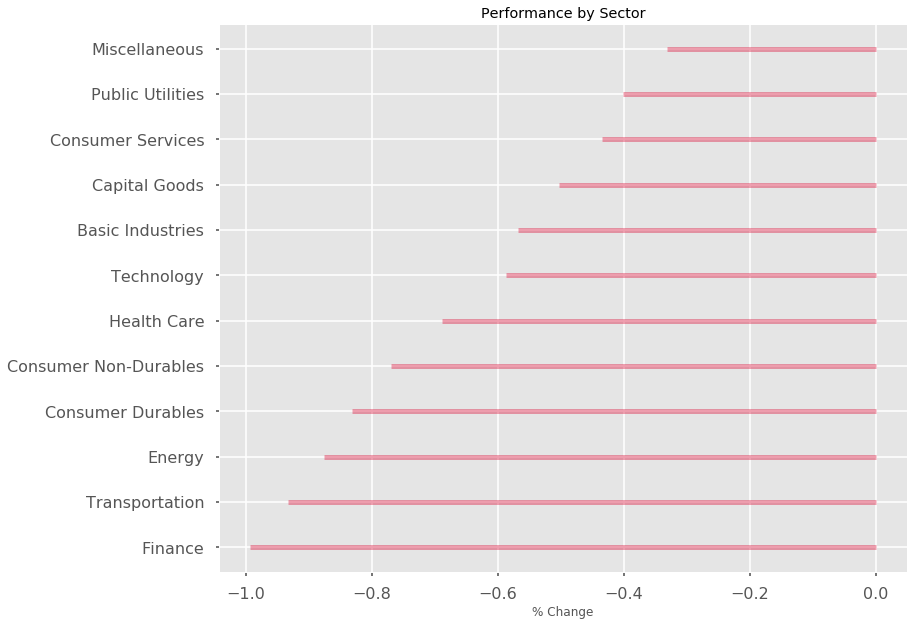

In [294]:
create_sector_diverging_bars(stocks_dif,"sector")

## Best Performing Stocks by Sector

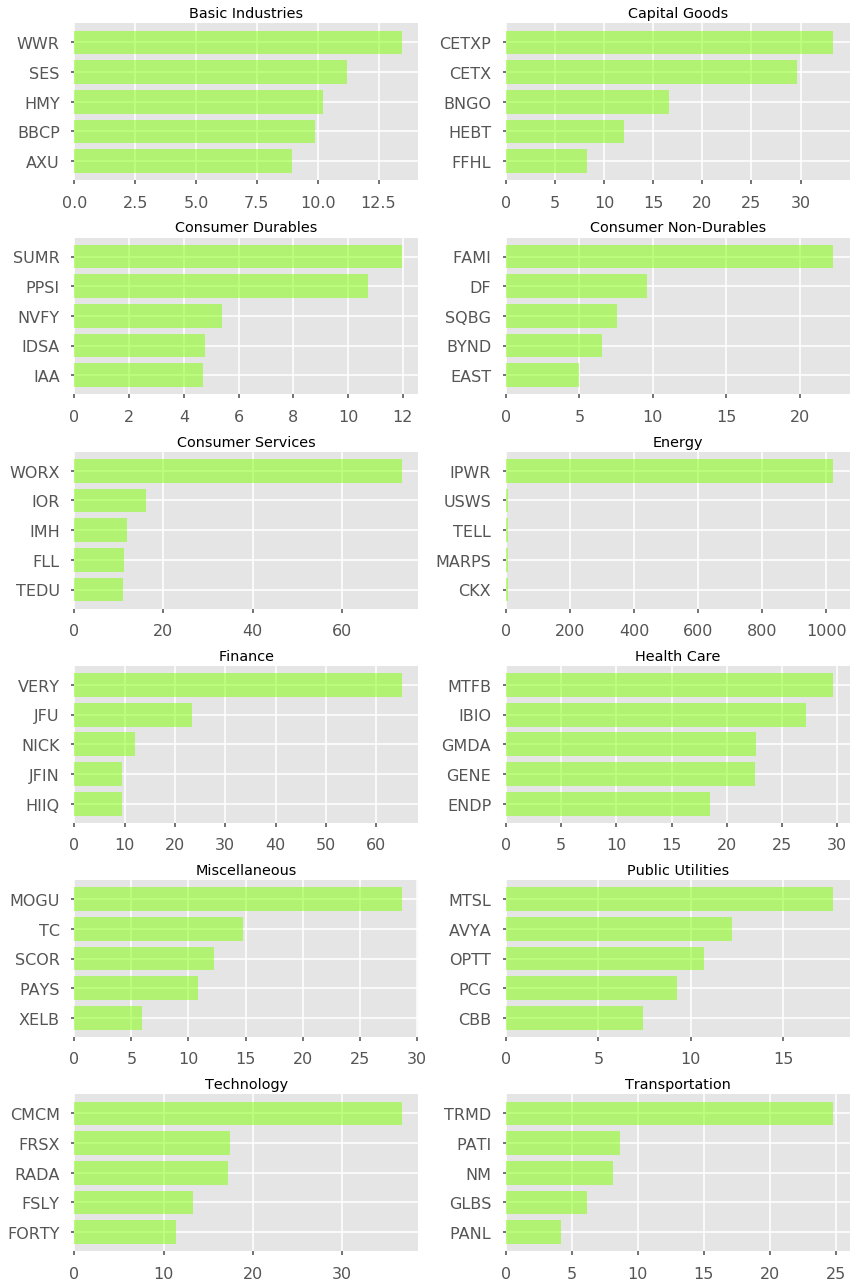

In [295]:
sector_name_group = stocks_dif.copy().loc[:,["symbol","sector","%_change"]].sort_values(by="%_change",ascending=False).groupby("sector")

fig = plt.figure(figsize=(12,18))
frame_index = 1
for group in sector_name_group.groups: 
    ax = fig.add_subplot(len(sector_name_group.groups)/2,2,frame_index)
    performers = sector_name_group.get_group(group).head()
    symbols = performers["symbol"]
    y_pos = np.arange(len(symbols))[ : :-1]
    performance = performers["%_change"]
    ax.barh(y_pos,performance,color="chartreuse",alpha=0.5)
    ax.set_title(group)
    plt.yticks(y_pos,symbols)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    frame_index += 1

plt.tight_layout()
plt.show()

## Worst Performing Stocks by Sector

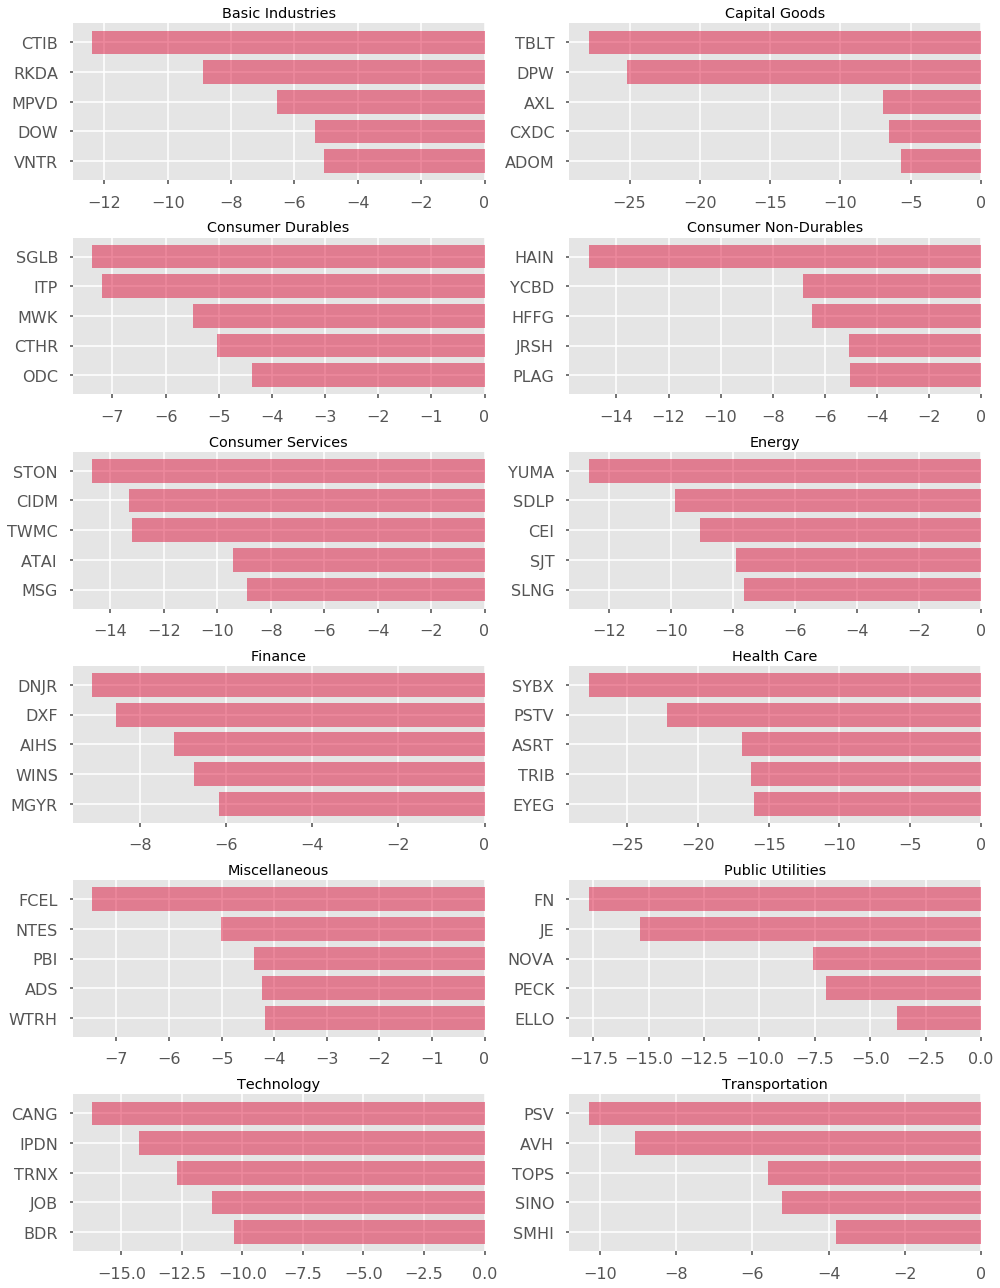

In [296]:
sector_name_group = stocks_dif.copy().loc[:,["symbol","sector","%_change"]].sort_values(by="%_change").groupby("sector")

fig = plt.figure(figsize=(14,18))
frame_index = 1
for group in sector_name_group.groups: 
    ax = fig.add_subplot(len(sector_name_group.groups)/2,2,frame_index)
    performers = sector_name_group.get_group(group).head()
    symbols = performers["symbol"]
    y_pos = np.arange(len(symbols))[ : :-1]
    performance = performers["%_change"]
    ax.barh(y_pos,performance,color="crimson",alpha=0.5)
    ax.set_title(group)
    plt.yticks(y_pos,symbols)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    frame_index += 1

plt.tight_layout()
plt.show()

## Best Performing Stocks by Exchange

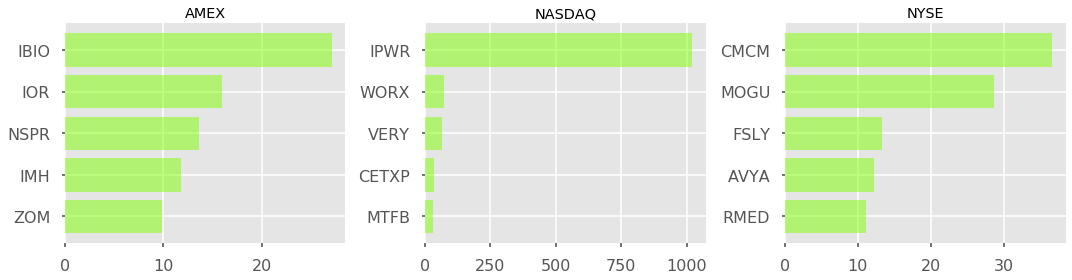

In [297]:
exchange_name_group = stocks_dif.copy().loc[:,["symbol","exchange","%_change"]].sort_values(by="%_change",ascending=False).groupby("exchange")

fig = plt.figure(figsize=(15,4))
frame_index = 1
for group in exchange_name_group.groups:
    ax = fig.add_subplot(1,len(exchange_name_group.groups),frame_index)
    performers = exchange_name_group.get_group(group).head()
    symbols = performers["symbol"]
    y_pos = np.arange(len(symbols))[ : :-1]
    performance = performers["%_change"]
    ax.barh(y_pos,performance,color="chartreuse",alpha=0.5)
    ax.set_title(group)
    plt.yticks(y_pos,symbols)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    frame_index += 1

plt.tight_layout()
plt.show()

## Worst Performing Stocks by Exchange

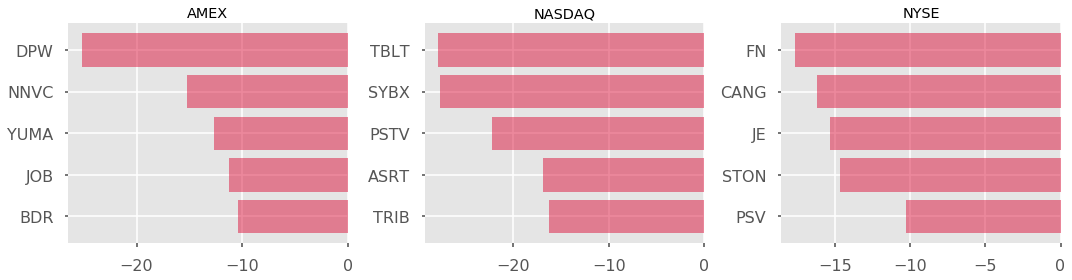

In [298]:
exchange_name_group = stocks_dif.copy().loc[:,["symbol","exchange","%_change"]].sort_values(by="%_change").groupby("exchange")

fig = plt.figure(figsize=(15,4))
frame_index = 1
for group in exchange_name_group.groups:
    ax = fig.add_subplot(1,len(exchange_name_group.groups),frame_index)
    performers = exchange_name_group.get_group(group).head()
    symbols = performers["symbol"]
    y_pos = np.arange(len(symbols))[ : :-1]
    performance = performers["%_change"]
    ax.barh(y_pos,performance,color="crimson",alpha=0.5)
    ax.set_title(group)
    plt.yticks(y_pos,symbols)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    frame_index += 1

plt.tight_layout()
plt.show()

## Best Performing Industries

In [299]:
def create_group_performance_table(df,parameter,best_or_worst,number):
    values_name = parameter+"_weighted_%_change"
    parameter_name = parameter.capitalize()
    df_copy = df.copy()
    group = df_copy.loc[:,[parameter,values_name]].groupby(parameter).sum()
    if best_or_worst == "best":
        group.sort_values(by=values_name,inplace=True,ascending=False)
    else:
        group.sort_values(by=values_name,inplace=True)
    return group.head(number)

In [300]:
create_group_performance_table(stocks_dif,"industry","best",5)

,industry_weighted_%_change
industry,
Diversified Electronic Products,3.930000
RETAIL: Building Materials,3.021598
Biotechnology: Electromedical & Electrotherapeutic Apparatus,2.135717
Movies/Entertainment,1.264372
Electronics Distribution,1.180000


## Worst Performing Industries

In [301]:
create_group_performance_table(stocks_dif,"industry","worst",5)

,industry_weighted_%_change
industry,
Consumer Electronics/Video Chains,-2.844734
Coal Mining,-2.192997
Agricultural Chemicals,-1.962098
Paper,-1.858708
Consumer: Greeting Cards,-1.760000


## Market Composition by Sector

In [302]:
def create_pie_chart(df,parameter):
    values_name = "mc_"+parameter+"_weight_overall"
    parameter_name = parameter.capitalize()
    df_copy = df.copy()
    group = df_copy.loc[:,[parameter,values_name]].groupby(parameter).sum()
    group.plot(kind='pie', subplots=True, figsize=(8, 8),legend=False,autopct='%1.1f%%')
    plt.title(parameter_name+"s Comprising US Stock Market by Market Cap.")
    plt.ylabel("")
    plt.show()

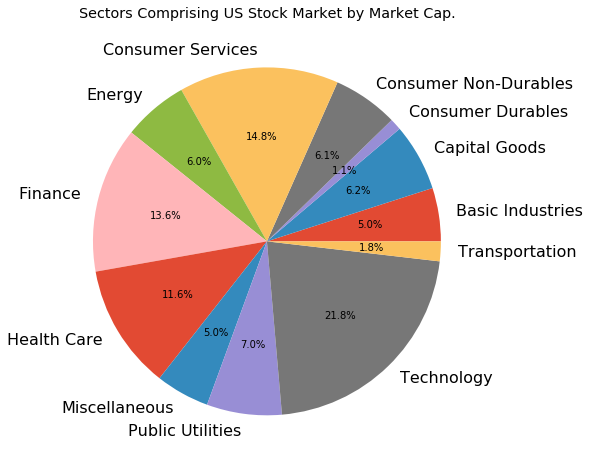

In [303]:
create_pie_chart(stocks_dif,"sector")

## Market Composition by Exchange

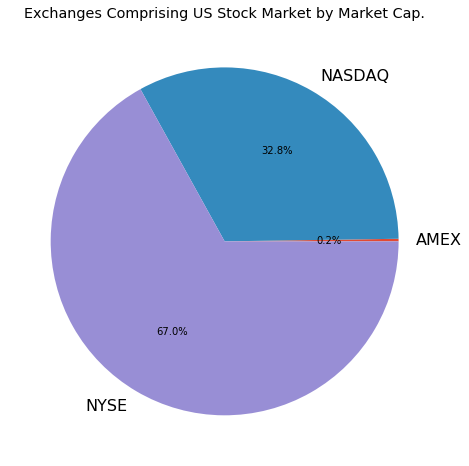

In [304]:
create_pie_chart(stocks_dif,"exchange")

## Closing Thoughts
The availability of this market information from NASDAQ for free is an excellent resource for financial analysts and hobbyists to monitor price movements in the US stock market. Although the CSV contains limited information, the data can still be leveraged to create a meaningful project.